### 1. Cài đặt thư viện cần thiết

In [12]:
# !pip install swig
# !pip install gymnasium[box2d]

In [13]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from collections import deque
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random

In [14]:
env = gym.make("LunarLander-v3",gravity=-10.0, enable_wind=True, wind_power=15.0, turbulence_power=1.5)

In [15]:
state_dim = env.observation_space.shape[0]  # = 8
action_dim = env.action_space.n             # = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )

    def forward(self, x):
        return self.model(x)

In [17]:
q_net = QNetwork(state_dim, action_dim).to(device)
target_net = QNetwork(state_dim, action_dim).to(device)
target_net.load_state_dict(q_net.state_dict())
target_net.eval()

QNetwork(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [18]:
optimizer = torch.optim.Adam(q_net.parameters(), lr=1e-4)
epsilon = 1.0
min_epsilon = 0.01
decay = 0.995
gamma = 0.99
batch_size = 256
episodes = 3000
target_update_freq = 10
reward_list = []
losses = []

In [19]:
memory = deque(maxlen=100000)

In [20]:
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            return q_net(state_tensor).argmax().item()


In [21]:
def train_step(batch_size, gamma):
    if len(memory) < batch_size:
        return

    # 1. Lấy minibatch ngẫu nhiên
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    # 2. Đưa về Tensor
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    dones = np.array(dones)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

    # 3. Tính Q hiện tại
    q_values = q_net(states).gather(1, actions)

    # 4. Tính Q mục tiêu
    with torch.no_grad():
        max_next_q = target_net(next_states).max(1)[0].unsqueeze(1)
        targets = rewards + gamma * max_next_q * (1 - dones)

    # 5. Tính loss và cập nhật mạng
    loss = nn.MSELoss()(q_values, targets)
    losses.append(loss.item())
    # 6. Cập nhật mạng
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [22]:
for ep in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = select_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        memory.append((state, action, reward, next_state, float(done)))
        state = next_state
        total_reward += reward

        train_step(batch_size, gamma)

    # Cập nhật target network mỗi vài episode
    if ep % target_update_freq == 0:
        target_net.load_state_dict(q_net.state_dict())

    epsilon = max(min_epsilon, epsilon * decay)
    reward_list.append(total_reward)
    print(f"Episode {ep}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")


Episode 0, Reward: -342.22, Epsilon: 0.995
Episode 1, Reward: -221.08, Epsilon: 0.990
Episode 2, Reward: -128.50, Epsilon: 0.985


Episode 3, Reward: -176.13, Epsilon: 0.980
Episode 4, Reward: -195.31, Epsilon: 0.975
Episode 5, Reward: -282.87, Epsilon: 0.970
Episode 6, Reward: -300.76, Epsilon: 0.966
Episode 7, Reward: -446.96, Epsilon: 0.961
Episode 8, Reward: -115.05, Epsilon: 0.956
Episode 9, Reward: -144.30, Epsilon: 0.951
Episode 10, Reward: -457.56, Epsilon: 0.946
Episode 11, Reward: -328.93, Epsilon: 0.942
Episode 12, Reward: -393.25, Epsilon: 0.937
Episode 13, Reward: -285.40, Epsilon: 0.932
Episode 14, Reward: -359.62, Epsilon: 0.928
Episode 15, Reward: -283.39, Epsilon: 0.923
Episode 16, Reward: -281.07, Epsilon: 0.918
Episode 17, Reward: -379.85, Epsilon: 0.914
Episode 18, Reward: -140.68, Epsilon: 0.909
Episode 19, Reward: -268.48, Epsilon: 0.905
Episode 20, Reward: -127.77, Epsilon: 0.900
Episode 21, Reward: -135.87, Epsilon: 0.896
Episode 22, Reward: -526.50, Epsilon: 0.891
Episode 23, Reward: -149.35, Epsilon: 0.887
Episode 24, Reward: -353.43, Epsilon: 0.882
Episode 25, Reward: -260.01, Epsilon: 0

In [23]:
#export target_net
import torch
torch.save(target_net.state_dict(), "lunarlander-wind-3k.pth")

In [24]:
testing = gym.make("LunarLander-v3", render_mode="rgb_array",gravity=-10.0, enable_wind=True, wind_power=15.0, turbulence_power=1.5)
testing = RecordVideo(testing, video_folder="video_wind_folder",episode_trigger=lambda ep: ep % 50 == 0, name_prefix="lunar_lander_wind", disable_logger=True)
total_success = 0
for _ in range(500):
    state, _ = testing.reset()
    done = False
    total_reward = 0
    while not done:
        action = target_net(torch.FloatTensor(state).unsqueeze(0).to(device)).argmax().item()
        next_state, reward, terminated, truncated, _ = testing.step(action)
        total_reward += reward
        done = terminated or truncated
        state = next_state
        testing.render()
    if(total_reward >= 200):
        total_success += 1

print(f"Total done: {total_success}/500, percentage: {total_success/500*100}%")

testing.close()

Total done: 399/500, percentage: 79.80000000000001%


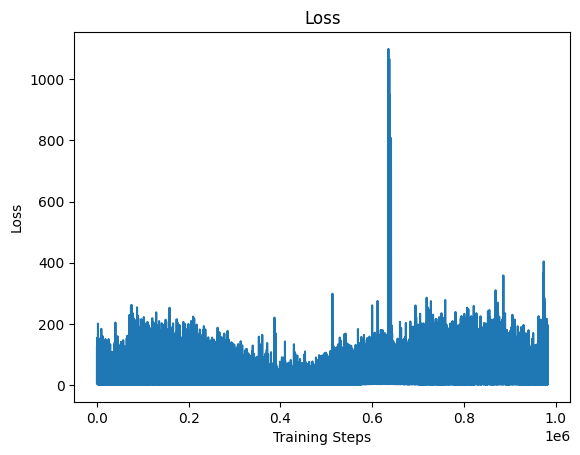

In [25]:
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()

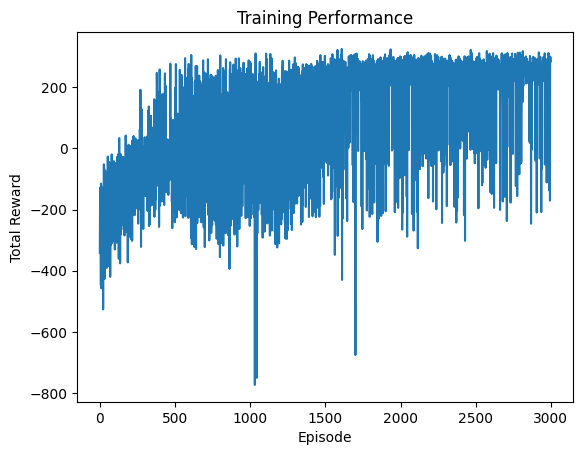

In [26]:
plt.plot(reward_list)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance")
plt.show()

In [27]:
import os
import glob
from IPython.display import Video

video_path = glob.glob("video_folder/*.mp4")[7]
Video(video_path, embed=True)
